In [73]:
import os
import numpy as np
import pandas as pd
import sklearn as sk

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Where we're working out of
PROJECT_ROOT_DIR = "."
FOLDER_ID = "building_lab"
DATA_FOLDER = "Denver Airport Building Models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER_ID)
#A function to save figures easily
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [74]:
def load_tmy3_data(climate_data, data_path=DATA_FOLDER):
    csv_path = os.path.join(data_path, climate_data)
    return pd.read_csv(csv_path,skiprows=[0], parse_dates=True)

def load_building_data(building_data, data_path=DATA_FOLDER):
    csv_path = os.path.join(data_path, building_data)
    return pd.read_csv(csv_path)


In [75]:
tmy3_data = load_tmy3_data("CO-Denver_Intl_Airport.tmy3")

In [76]:
tmy3_data.head(15)

,Date (MM/DD/YYYY),Time (HH:MM),ETR (W/m^2),ETRN (W/m^2),GHI (W/m^2),GHI source,GHI uncert (%),DNI (W/m^2),DNI source,DNI uncert (%),...,Alb (unitless),Alb source,Alb uncert (code),Lprecip depth (mm),Lprecip quantity (hr),Lprecip source,Lprecip uncert (code),PresWth (METAR code),PresWth source,PresWth uncert (code)
0,01/01/1995,01:00,0,0,0,1,0,0,1,0,...,0.22,F,8,0,1,D,9,0,C,8
1,01/01/1995,02:00,0,0,0,1,0,0,1,0,...,0.22,F,8,0,1,D,9,0,C,8
2,01/01/1995,03:00,0,0,0,1,0,0,1,0,...,0.22,F,8,0,1,D,9,0,C,8
3,01/01/1995,04:00,0,0,0,1,0,0,1,0,...,0.22,F,8,0,1,D,9,0,C,8
4,01/01/1995,05:00,0,0,0,1,0,0,1,0,...,0.22,F,8,0,1,D,9,0,C,8
5,01/01/1995,06:00,0,0,0,1,0,0,1,0,...,0.22,F,8,0,1,D,9,0,C,8
6,01/01/1995,07:00,0,0,0,1,0,0,1,0,...,0.22,F,8,0,1,D,9,0,C,8
7,01/01/1995,08:00,45,908,9,1,17,17,1,21,...,0.22,F,8,0,1,D,9,0,C,8
8,01/01/1995,09:00,248,1415,89,1,17,73,1,21,...,0.22,F,8,0,1,D,9,0,C,8
9,01/01/1995,10:00,433,1415,266,1,17,494,1,21,...,0.22,F,8,0,1,D,9,0,C,8


In [77]:
#Strips the year out of the first column
tmy3_data.iloc[:,0] = tmy3_data.iloc[:,0].str.slice(0,5)

#Important categories
tmy3_data = tmy3_data.iloc[:,[0,1,31,37,40,43,46]]

#Rename columns
tmy3_data = tmy3_data.rename(columns={'Date (MM/DD/YYYY)':'date', 'Time (HH:MM)':'time',
                           'Dry-bulb (C)': 'temp', 'RHum (%)':'humidity',
                          'Pressure (mbar)': 'pressure', 'Wdir (degrees)': 'wind_dir',
                          'Wspd (m/s)':'wind_speed'})

In [78]:
tmy3_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 7 columns):
date          8760 non-null object
time          8760 non-null object
temp          8760 non-null float64
humidity      8760 non-null int64
pressure      8760 non-null int64
wind_dir      8760 non-null int64
wind_speed    8760 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 479.1+ KB


Denver's scatter matrix for Stand-alone Retail
RMSE for Stand-alone Retail is :  0.9298443272237578
_________________________________________
Denver's scatter matrix for Medium Office
RMSE for Medium Office is :  2.0356819581257666
_________________________________________
Denver's scatter matrix for Warehouse
RMSE for Warehouse is :  0.3919209960274535
_________________________________________
Denver's scatter matrix for Small Hotel
RMSE for Small Hotel is :  0.4741134490406529
_________________________________________


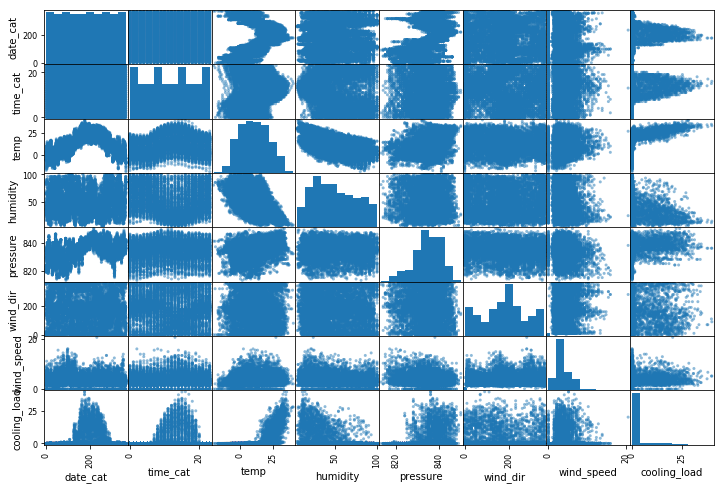

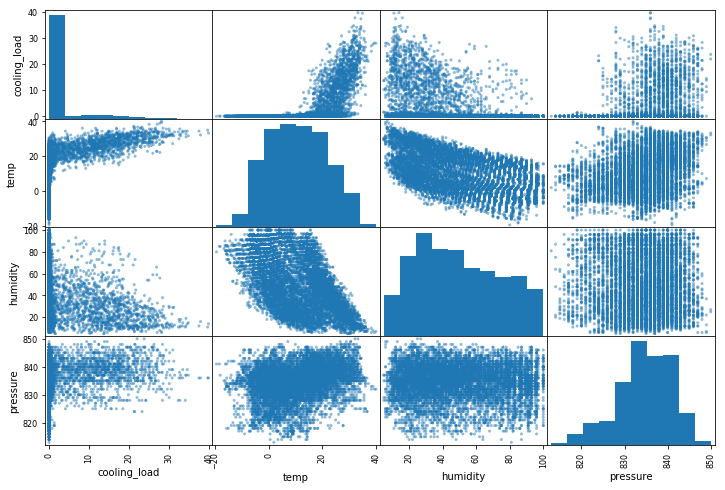

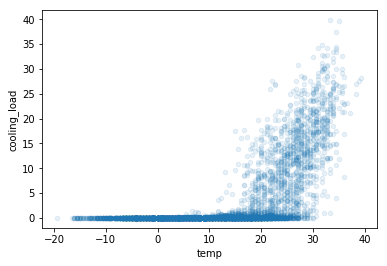

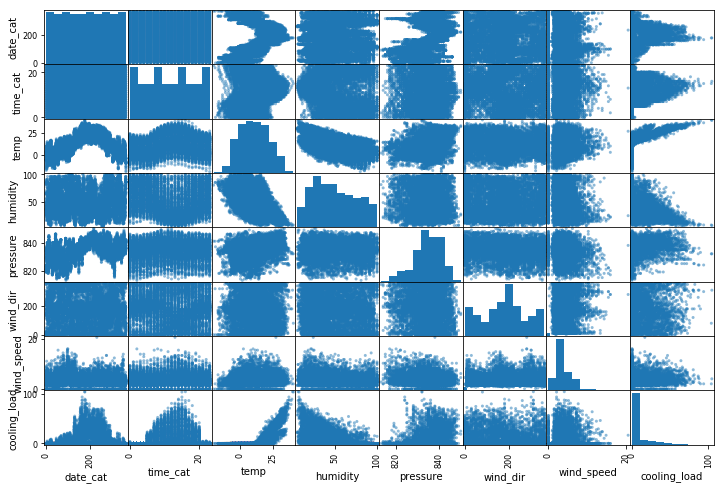

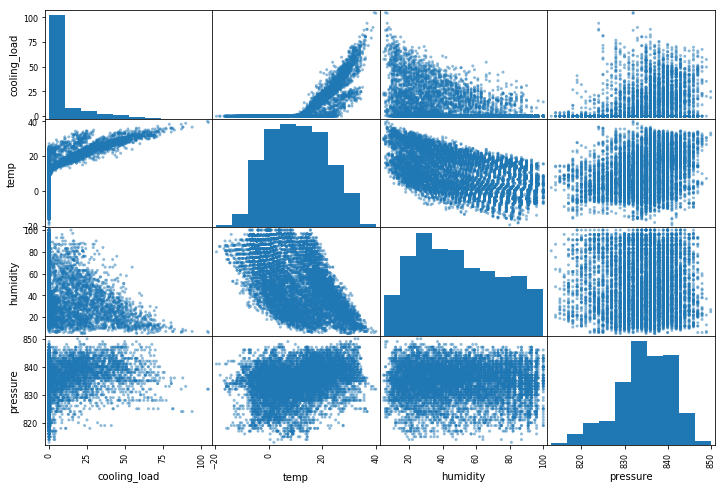

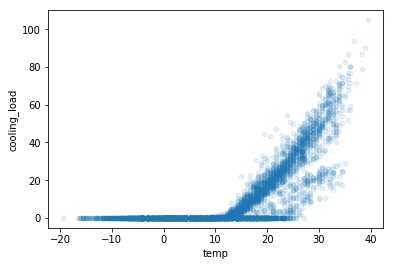

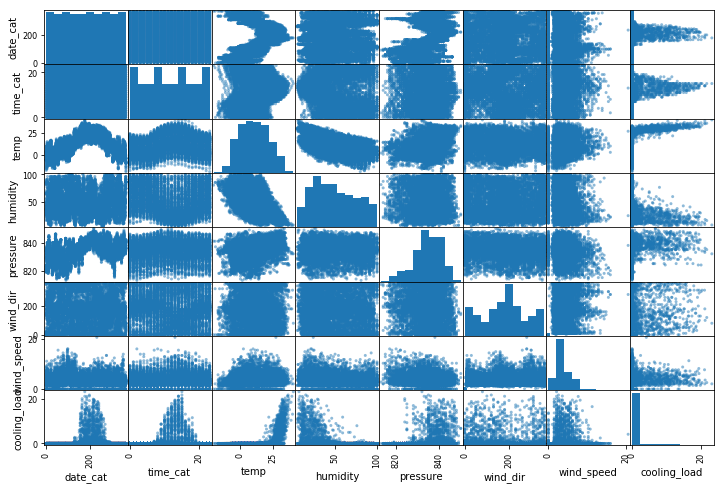

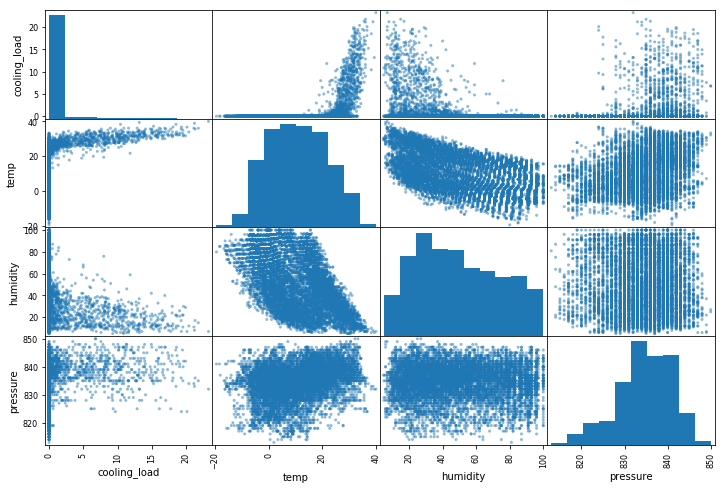

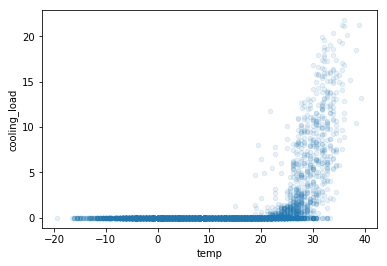

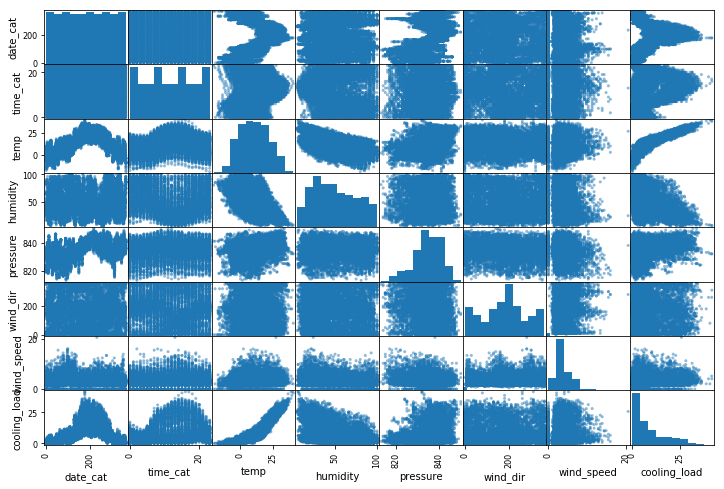

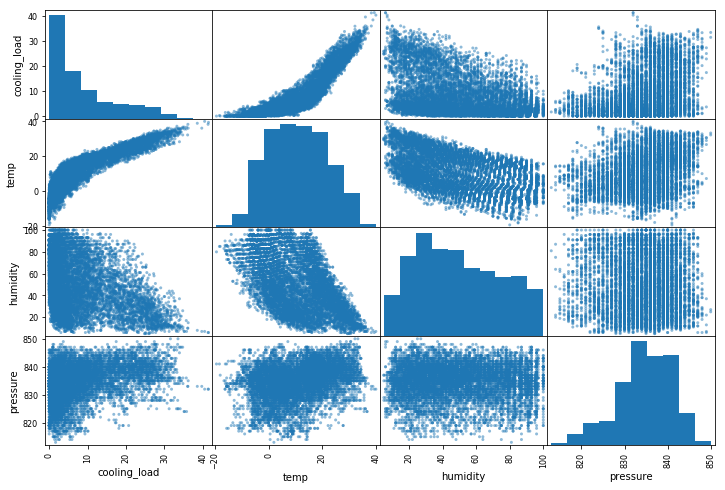

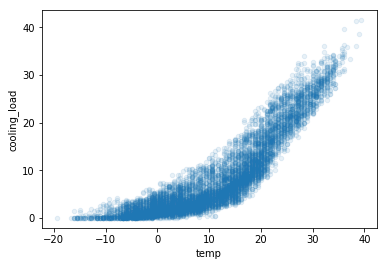

In [84]:
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Pick regression model
MODEL = 'Forest' # or 'Linear' or 'Tree'

# City size.
city_descriptors = [5, 5, 3, 2]
num_med_off = 5
num_small_hotel = 2
num_stand_alone = 5
num_warehouse = 3

# Model's feature.
attributes = ['cooling_load', 'temp', 'humidity', 'pressure']

# Study the buildings.
build_energy_data_list = []
rmse_results = []
models = []
test_sets = []
goal_test_label_sets = []

csvs_list = ["RefBldgStand-aloneRetailNew2004_v1.3_7.1_5B_USA_CO_BOULDER.csv",
             "RefBldgMediumOfficeNew2004_v1.3_7.1_5B_USA_CO_BOULDER.csv",
             "RefBldgWarehouseNew2004_v1.3_7.1_5B_USA_CO_BOULDER.csv",
             "RefBldgSmallHotelNew2004_v1.3_7.1_5B_USA_CO_BOULDER.csv"]

city_buildings = ["Stand-alone Retail", "Medium Office", "Warehouse", "Small Hotel"]

for csv_file, building in zip(csvs_list, city_buildings):
    building_energy_data = load_building_data(csv_file)
    # Store the energy data.
    build_energy_data_list.append(building_energy_data)
    #The combined cooling energy with matching date and time from the feature set
    combined_set = pd.DataFrame(tmy3_data)
    combined_set = combined_set.join(building_energy_data.iloc[:,3])
    combined_set = combined_set.rename(columns={'Cooling:Electricity [kW](Hourly)':'cooling_load'})
    #Clean data.
    date_cat = combined_set['date']
    date_cat_encoded, date_categories = date_cat.factorize()
    time_cat = combined_set['time']
    time_cat_encoded, time_categories = time_cat.factorize()
    #
    combined_set = pd.DataFrame({'date_cat':date_cat_encoded,'time_cat':time_cat_encoded})
    combined_set = pd.concat([combined_set,tmy3_data.iloc[:,2:7],building_energy_data.iloc[:,3]],axis=1)
    combined_set = combined_set.rename(columns={'Cooling:Electricity [kW](Hourly)':'cooling_load'})
    
    # Inspect the data.
    # Scatter matrix
    print("Denver's scatter matrix for " + building)
    scatter_matrix(combined_set, figsize = (12,8))
    # Attributes scatte matrix
    scatter_matrix(combined_set[attributes], figsize = (12,8))
    corr_matrix = combined_set.corr()
    corr_matrix["cooling_load"]
    
    # Train.
    train_set, test_set = train_test_split(combined_set, test_size=0.2, random_state=42)
    # Keep train set safe.
    train_set_safe = train_set.copy()
    # Correlation data.
    corr_matrix = train_set.corr()
    corr_matrix["cooling_load"]
    # PLot.
    train_set.plot(kind='scatter', x = 'temp', y = 'cooling_load', alpha = 0.1)
    # Scaling train set.
    feature_set_train = train_set.drop('cooling_load', axis =1)
    label_set_train = train_set['cooling_load'].copy()
    std_scaler = StandardScaler()
    scaled_feature_set_train = std_scaler.fit_transform(feature_set_train)
    
    #****************** Regression **********************#
    if MODEL == 'Linear':
        # Use linear regression : Fitting.
        lin_reg = LinearRegression()
        lin_reg.fit(scaled_feature_set_train, label_set_train)
        # Store my current model (for some building).
        models.append(lin_reg)
    elif MODEL == 'Tree':
        # Use decision tree.    
        tree_reg = DecisionTreeRegressor(random_state = 42)
        ##tree_reg.fit(feature_set_train, label_set_train)
        ##tree_reg.fit(min_max_feature_set_train, label_set_train)
        tree_reg.fit(scaled_feature_set_train, label_set_train)
        models.append(tree_reg)
    elif MODEL == 'Forest':
        # Use random forest.
        forest_reg = RandomForestRegressor(random_state = 42)
        forest_reg.fit(scaled_feature_set_train, label_set_train)
        models.append(forest_reg)
    else : print("Error!")
    #**********************************************************#
    # Scale test set.
    feature_set_test = test_set.drop('cooling_load', axis =1)
    label_set_test = test_set['cooling_load'].copy()
    # You should not fit test data!!!
    scaled_feature_set_test = std_scaler.transform(feature_set_test)
    test_sets.append(scaled_feature_set_test)
    goal_test_label_sets.append(label_set_test)
      
    #****************************************#
    # Results.
    if MODEL == 'Linear':
        lin_energy_predictions = lin_reg.predict(feature_set_train)
        lin_mse = mean_squared_error(label_set_train, lin_energy_predictions)
        lin_rmse = np.sqrt(lin_mse)
    elif MODEL == 'Tree':
        tree_energy_predictions = tree_reg.predict(feature_set_train)
        tree_mse = mean_squared_error(label_set_train, tree_energy_predictions)
        tree_rmse = np.sqrt(tree_mse)
    elif MODEL == 'Forest':
        forest_energy_predictions = forest_reg.predict(scaled_feature_set_train)
        forest_mse = mean_squared_error(label_set_train, forest_energy_predictions)
        forest_rmse = np.sqrt(forest_mse)
    else : print("Error!")
    #****************************************#
    
    # Store rmse.
    if MODEL == 'Linear':
        rmse_results.append(lin_rmse)
    elif MODEL == 'Tree':
        rmse_results.append(tree_rmse)
    elif MODEL == 'Forest':
        rmse_results.append(forest_rmse)
    else : print("Error!")
    
    
    print("RMSE for " + building + " is : ", forest_rmse)
    
    # Linear regression Version : Make the plot.
    #plt.clf()
    #plt.plot(feature_set_train["temp"], label_set_train, 'o', color='grey', label = 'Actual Output')
    #plt.plot(feature_set_train["temp"], lin_energy_predictions, 'o', color='red', label = 'Predicted Output')
    #plt.xlabel("temperature")
    #plt.ylabel("Energy")
    #plt.title("Linear Regression - Training Set")
    #plt.legend()
    #plt.savefig("linear_regression_train_set.png")
    
    # Decision Tree Version : Make the plot.
    #plt.clf()
    #plt.plot(feature_set_train["humidity"], label_set_train, 'o', color='grey', label = 'Actual Output')
    #plt.plot(feature_set_train["humidity"], tree_energy_predictions, 'o', color='red', label = 'Predicted Output')
    #plt.xlabel("Humidity")
    #plt.ylabel("Enegy")
    #plt.title("Decision Tree Regression - Training Set")
    #plt.legend()
    #plt.ylim((-1, 120))
    #lt.xlim((-1,120))
    #plt.savefig("decision_tree_regression_train_set.png")

    print("_________________________________________")
    

In [91]:
# Results combination.
index = 0
energy_total = []
#energy_total_goal = []

for num_of_buildings in city_descriptors:
    model = models[index]
    test_set = test_sets[index]
    goal_test_label_set = goal_test_label_sets[index]
    energy_total.append(num_of_buildings * model.predict(test_set))
    #energy_total_goal.append(num_of_buildings * goal_test_label_set)
    index += 1
        
for i in range(0, len(test_set)-1, 1):
    energy_for_ith = 0
    #energy_for_ith_goal = energy_total_goal[i]
    for j in range(0, len(city_descriptors)-1, 1):
        energy_for_ith += energy_total[j][i]
    print("Energy for " , i, " is :", energy_for_ith)
    
# RMSE
# Compute goal


Energy for  0  is : 132.08499750053375
Energy for  1  is : 370.5689960735431
Energy for  2  is : 406.7228220541459
Energy for  3  is : 4.742522960018355e-06
Energy for  4  is : 98.00642098127007
Energy for  5  is : 0.042638531477948625
Energy for  6  is : 52.526631840457576
Energy for  7  is : 2.1829595896821368e-06
Energy for  8  is : 46.24683709428822
Energy for  9  is : 4.5798530216750265e-06
Energy for  10  is : 2.049330642462672e-06
Energy for  11  is : 4.51509674607495e-06
Energy for  12  is : 3.87574284132844e-06
Energy for  13  is : 340.10508611174396
Energy for  14  is : 92.08194277487506
Energy for  15  is : 407.58676371136005
Energy for  16  is : 3.87574284132844e-06
Energy for  17  is : 1.2617824919424607e-05
Energy for  18  is : 5.588575704369757e-07
Energy for  19  is : 36.68330868200337
Energy for  20  is : 3.87574284132844e-06
Energy for  21  is : 38.59527275795377
Energy for  22  is : 230.41029040888762
Energy for  23  is : 1.2882135103761731e-05
Energy for  24  is : 3

Energy for  284  is : 228.99464423650096
Energy for  285  is : 406.18790423690695
Energy for  286  is : 0.02047968106272044
Energy for  287  is : 3.87574284132844e-06
Energy for  288  is : 0.11412528453430673
Energy for  289  is : 2.049330642462672e-06
Energy for  290  is : 3.3137590150721e-06
Energy for  291  is : 3.87574284132844e-06
Energy for  292  is : 100.81928356439289
Energy for  293  is : 69.5651045256229
Energy for  294  is : 3.87574284132844e-06
Energy for  295  is : 28.793235357159567
Energy for  296  is : 200.23295961234078
Energy for  297  is : 3.87574284132844e-06
Energy for  298  is : 107.23645114153919
Energy for  299  is : 3.3648944207850002
Energy for  300  is : 22.32728492048857
Energy for  301  is : 294.535861933344
Energy for  302  is : 8.338718967505288
Energy for  303  is : 1.8920879246792325e-05
Energy for  304  is : 335.176992532669
Energy for  305  is : 203.71674871091398
Energy for  306  is : 379.304101469145
Energy for  307  is : 178.6178201845186
Energy fo

Energy for  522  is : 1.1232191193261833e-05
Energy for  523  is : 90.56114148599283
Energy for  524  is : 1.4358709141067134e-05
Energy for  525  is : 3.87574284132844e-06
Energy for  526  is : 1.4358709141067134e-05
Energy for  527  is : 3.750040089423462e-06
Energy for  528  is : 2.2516408220832792e-06
Energy for  529  is : 3.87574284132844e-06
Energy for  530  is : 14.111930682791218
Energy for  531  is : 3.87574284132844e-06
Energy for  532  is : 110.17414597630858
Energy for  533  is : 179.92229513035946
Energy for  534  is : 1.137140472618854e-05
Energy for  535  is : 5.588575704369757e-07
Energy for  536  is : 7.611677500575832e-07
Energy for  537  is : 2.8810611583586085e-06
Energy for  538  is : 0.08504695782780673
Energy for  539  is : 3.1503264259542323e-06
Energy for  540  is : 3.87574284132844e-06
Energy for  541  is : 158.5903420869282
Energy for  542  is : 1.2882135103761731e-05
Energy for  543  is : 35.50336042266307
Energy for  544  is : 1.284273985811184e-06
Energy f

Energy for  908  is : 190.0957794455339
Energy for  909  is : 1.2882135103761731e-05
Energy for  910  is : 56.12322558244008
Energy for  911  is : 3.87574284132844e-06
Energy for  912  is : 2.397729004861658e-05
Energy for  913  is : 1.284273985811184e-06
Energy for  914  is : 5.588575704369757e-07
Energy for  915  is : 3.87574284132844e-06
Energy for  916  is : 2.5193660122439905
Energy for  917  is : 2.4200475259738613e-05
Energy for  918  is : 3.87574284132844e-06
Energy for  919  is : 0.014180097418120437
Energy for  920  is : 1.3239142270884635e-06
Energy for  921  is : 3.140247604073073
Energy for  922  is : 408.2498377923861
Energy for  923  is : 4.949740484121186e-06
Energy for  924  is : 0.19672688191807042
Energy for  925  is : 360.70285127118404
Energy for  926  is : 0.4566132838030704
Energy for  927  is : 3.87574284132844e-06
Energy for  928  is : 3.87574284132844e-06
Energy for  929  is : 49.975965562957256
Energy for  930  is : 252.552005123726
Energy for  931  is : 16.9

Energy for  1158  is : 436.33090716629897
Energy for  1159  is : 53.460352395991016
Energy for  1160  is : 3.110686184676953e-06
Energy for  1161  is : 2.2014869149536227e-05
Energy for  1162  is : 66.30097462630707
Energy for  1163  is : 3.87574284132844e-06
Energy for  1164  is : 1.5184229164475704
Energy for  1165  is : 0.7487135300875704
Energy for  1166  is : 0.2887222710709114
Energy for  1167  is : 1.2169016642415026e-05
Energy for  1168  is : 1.2169016642415026e-05
Energy for  1169  is : 310.71865673336595
Energy for  1170  is : 2.049330642462672e-06
Energy for  1171  is : 1.284273985811184e-06
Energy for  1172  is : 3.87574284132844e-06
Energy for  1173  is : 3.87574284132844e-06
Energy for  1174  is : 0.15196385354227132
Energy for  1175  is : 41.548060615209145
Energy for  1176  is : 5.588575704369757e-07
Energy for  1177  is : 32.56017393771925
Energy for  1178  is : 5.507579616669843e-06
Energy for  1179  is : 583.294820933055
Energy for  1180  is : 21.658730690872517
Ener

Energy for  1408  is : 328.77613483370396
Energy for  1409  is : 0.00377911006383409
Energy for  1410  is : 3.87574284132844e-06
Energy for  1411  is : 0.013792533881293265
Energy for  1412  is : 12.242423449019999
Energy for  1413  is : 1.284273985811184e-06
Energy for  1414  is : 3.750040089423462e-06
Energy for  1415  is : 1.2169016642415026e-05
Energy for  1416  is : 240.73613394399942
Energy for  1417  is : 1.89783437748
Energy for  1418  is : 258.12521067344
Energy for  1419  is : 2.1829595896821368e-06
Energy for  1420  is : 0.008572385590603764
Energy for  1421  is : 177.2886526545947
Energy for  1422  is : 3.110686184676953e-06
Energy for  1423  is : 0.18753169146327042
Energy for  1424  is : 1.2617824919424607e-05
Energy for  1425  is : 137.3066545550298
Energy for  1426  is : 35.33445421344024
Energy for  1427  is : 159.3061006823487
Energy for  1428  is : 4.51509674607495e-06
Energy for  1429  is : 1.1547310298205177e-05
Energy for  1430  is : 353.86311178983397
Energy for 

Energy for  1658  is : 206.09034954422603
Energy for  1659  is : 85.124444688975
Energy for  1660  is : 1.4865841654317917e-06
Energy for  1661  is : 5.588575704369757e-07
Energy for  1662  is : 3.87574284132844e-06
Energy for  1663  is : 0.0968317121935961
Energy for  1664  is : 4.5798530216750265e-06
Energy for  1665  is : 3.110686184676953e-06
Energy for  1666  is : 3.87574284132844e-06
Energy for  1667  is : 1.284273985811184e-06
Energy for  1668  is : 208.83816278278724
Energy for  1669  is : 2.2516408220832792e-06
Energy for  1670  is : 3.87574284132844e-06
Energy for  1671  is : 1.3239142270884635e-06
Energy for  1672  is : 0.9687885873783706
Energy for  1673  is : 388.686120218725
Energy for  1674  is : 1.0421003281165704
Energy for  1675  is : 2.049330642462672e-06
Energy for  1676  is : 3.87574284132844e-06
Energy for  1677  is : 1.4423373712248319e-05
Energy for  1678  is : 60.761884714832576
Energy for  1679  is : 82.96506046638207
Energy for  1680  is : 105.99239497244838


In [81]:
# City results.